# Binary classification

In [ ]:
import numpy as np
import numpy as np
# from ecog_band.models import SVMBinClassifier
# from ecog_band.models import SVMBinClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import os
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# from ecog_band.utils import *
# from Ecog_pretrain.ecog_band.utils import *
# from Ecog_pretrain.ecog_band.solver import Nfold_solver
import pandas as pd
# from ecog_band.datasetExcludeBand import CustomDatasetExcband
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch
from torch.utils import data as Data
from sklearn.model_selection import GridSearchCV,train_test_split
import torch.nn as nn
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
import scipy.io as scio
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.patches as patches
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


HS = 45
freq = 400
elec = 74
bands_list = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 70),
    'high gamma':(70,150),
    'else2':(150,min(freq/2, 300))
}
HS_list = [45,47,48,50,54,71,76,78,73]
freq_list = [400]
mpl.rcParams['font.size'] =10

## define model

In [2]:
class BandErpDataset(Data.Dataset):
    def __init__(self, band_covert_data_all, band_overt_data_all, elec, band):
        '''band_covert_data_all, z_band_read_data_all为所有frequency bands的数据字典，每个band对应一个任务的所有trail的数据
        band_covert_data_all = {band : data(shape = n_trails, n_electrodes, n_timepoints)}
        '''
        super().__init__()
        self.data = [] # 存Ecog数据，shape为（n_samples x n_features)
        self.labels = [] # 存label, shape=（n_samples），cue标记为0，read标记为1
        # load aligned data and plot average signal
        cue_data = band_covert_data_all[band]
        read_data = band_overt_data_all[band] 

        X=np.concatenate((cue_data[:, elec, :], read_data[:, elec, :]),axis=0)
        # X = X.reshape(-1, X.shape[1]*X.shape[2])

        y_cue=np.array([0]*cue_data.shape[0])
        y_read=np.array([1]*read_data.shape[0])
        y=np.concatenate((y_cue,y_read),axis=0)

        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)
    
    def get_data_labels(self):
        return self.data, self.labels

    def __getitem__(self, idx):
        # Return a tuple of (data, label) and convert data to a PyTorch tensor
        # print(self.data.shape)
        return torch.tensor(abs(self.data[idx]), dtype=torch.float), torch.tensor(self.labels[idx])
    
class SVMBinClassifier(nn.Module):
    def __init__(self):
        # tuned_parameters = [{'kernel': ['linear'], 'C': [0.1, 1], 'gamma': [0.01]}]
        # self.model = GridSearchCV(SVC(), tuned_parameters, scoring='accuracy', n_jobs=1)
        self.model = SVC(C=0.1, kernel='sigmoid')
        self.pca = PCA(n_components=0.95)
    
    def train(self, x_train, y_train):
        X_train_pca = self.pca.fit_transform(x_train)
        self.model.fit(X_train_pca, y_train)
        # plt_learning_curve(self.model, X_train_pca, y_train, cv=5)
        # best_params = self.model.best_params_
        # return best_params
    
    def predict(self, x_test):
        X_test_pca = self.pca.transform(x_test)
        return self.model.predict(X_test_pca)
    
    def evaluate(self, X_test, y_test):
        # X_test_pca = self.pca.transform(X_test)
        y_pred = self.predict(X_test)
        # y_pred = cross_val_predict(self.model, X=X_test_pca, y=y_test, cv=5)
        return y_pred

## calculate BC accuracy for each frequency band

In [14]:
def cal_bc_sig_HS_band(HS, freq, bands_list, elec_list, band_covert_data_all, band_overt_data_all):
    '''
    discription: 计算所有band在256个电极上的accuracy
    band_covert_data_all，band_overt_data_all是所有band的数据字典（z-score之后的）
    return：bands_acc 字典，每个band的acc是一个长度为256的list {band: [accList], band:[], ...}
    新增：返回每个任务下的分类准确率bands_acc_overt， bands_acc_covert
    '''
    bands_acc = {} # 存储每个band的分类准确率
    bands_acc_covert = {}  # 新增：存储每个band在covert任务下的分类准确率
    bands_acc_overt = {}  # 新增：存储每个band在overt任务下的分类准确率
    for band in bands_list.keys():
        band_elec_acc = []
        band_elec_acc_covert = []  # 新增：存储每个电极在covert任务下的准确率
        band_elec_acc_overt = []  # 新增：存储每个电极在overt任务下的准确率
        for i, elec in enumerate(elec_list):
            data_loader = BandErpDataset(band_covert_data_all, band_overt_data_all, elec, band)
            data_all, labels_all = data_loader.get_data_labels()
            # print(f'data_shape: {data_all.shape}, data_label_shape:{labels_all.shape}')

            X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=1/6, random_state=42, shuffle=True)
            # svm = DecisionTreeBinClassifier()
            svm = SVMBinClassifier()
            svm.train(x_train=X_train, y_train=y_train)

            y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
            elec_acc = accuracy_score(y_test, y_pred)
            band_elec_acc.append(elec_acc)
            
            # 计算 covert 和 overt 的分类准确率
            covert_indices = np.where(y_test == 0)[0]  # covert 的标签为 0
            overt_indices = np.where(y_test == 1)[0]  # overt 的标签为 1
            
            if len(covert_indices) > 0:  # 确保covert有数据
                elec_acc_covert = accuracy_score(y_test[covert_indices], y_pred[covert_indices])
                band_elec_acc_covert.append(elec_acc_covert)
            
            if len(overt_indices) > 0:  # 确保overt有数据
                elec_acc_overt = accuracy_score(y_test[overt_indices], y_pred[overt_indices])
                band_elec_acc_overt.append(elec_acc_overt)
        
        bands_acc[band] = band_elec_acc
        bands_acc_covert[band] = band_elec_acc_covert  # 新增：存储每个band在covert任务下的分类准确率
        bands_acc_overt[band] = band_elec_acc_overt  # 新增：存储每个band在overt任务下的分类准确率
        
        print(f'Accuracy for HS{HS}-freq{freq} on {band} band is Done! acc_list={band_elec_acc}')
    
    return bands_acc, bands_acc_covert, bands_acc_overt
            


In [15]:
save_path = f'/public/DATA/covert_reading/HS_preanalysis_ECoG/HS{HS}/aligned_data'
covert_data = np.load(os.path.join(save_path, f'covert_allbands_{freq}hz.npy'), allow_pickle=True).item()
overt_data = np.load(os.path.join(save_path, f'overt_allbands_{freq}hz.npy'), allow_pickle=True).item()

elec_list = [i for i in range(0, 256)]
HS_list = [45]
freq_list = [400]
save_acc_dir = f'/public/DATA/covert_reading/bands_acc/'
os.makedirs(save_acc_dir, exist_ok=True)

for HS in HS_list:
    for freq in freq_list:
        save_acc_path = os.path.join(save_acc_dir, f'HS{HS}', f'{freq}')
        os.makedirs(save_acc_path, exist_ok=True)
        bands_acc, bands_acc_covert, bands_acc_overt = cal_bc_sig_HS_band(HS, freq, bands_list, elec_list, covert_data, overt_data)
        np.save(os.path.join(save_acc_path, 'bands_acc.npy'), bands_acc)
        np.save(os.path.join(save_acc_path, 'bands_acc_covert.npy'), bands_acc_covert)
        np.save(os.path.join(save_acc_path, 'bands_acc_overt.npy'), bands_acc_overt)


Accuracy for HS45-freq400 on delta band is Done! acc_list=[0.576271186440678, 0.5, 0.5932203389830508, 0.5, 0.5169491525423728, 0.559322033898305, 0.6694915254237288, 0.4915254237288136, 0.5084745762711864, 0.4745762711864407, 0.6016949152542372, 0.5338983050847458, 0.5, 0.5169491525423728, 0.5254237288135594, 0.4576271186440678, 0.5169491525423728, 0.5423728813559322, 0.5677966101694916, 0.5423728813559322, 0.4576271186440678, 0.5847457627118644, 0.7711864406779662, 0.6271186440677966, 0.5847457627118644, 0.4915254237288136, 0.5847457627118644, 0.7203389830508474, 0.6186440677966102, 0.4745762711864407, 0.4576271186440678, 0.4661016949152542, 0.5508474576271186, 0.5423728813559322, 0.576271186440678, 0.576271186440678, 0.6779661016949152, 0.6440677966101694, 0.5508474576271186, 0.6101694915254238, 0.5847457627118644, 0.5508474576271186, 0.6440677966101694, 0.5847457627118644, 0.4915254237288136, 0.5847457627118644, 0.4745762711864407, 0.5508474576271186, 0.4067796610169492, 0.50847457

In [16]:
save_acc_path = os.path.join(f'/public/DATA/covert_reading/bands_acc', f'HS{HS}', f'{freq}')
bands_acc = np.load(f'/public/DATA/covert_reading/bands_acc/HS{HS}/{freq}/bands_acc.npy', allow_pickle=True).item()
bands_acc_covert = np.load(f'/public/DATA/covert_reading/bands_acc/HS{HS}/{freq}/bands_acc_covert.npy', allow_pickle=True).item()
bands_acc_overt = np.load(f'/public/DATA/covert_reading/bands_acc/HS{HS}/{freq}/bands_acc_overt.npy', allow_pickle=True).item()

for band in bands_list:
    acc_mean = np.mean(bands_acc[band])
    acc_covert_mean = np.mean(bands_acc_covert[band])
    acc_overt_mean = np.mean(bands_acc_overt[band])

    print(f'{band} accuracy mean: {acc_mean}, covert accuracy mean: {acc_covert_mean}, overt accuracy mean: {acc_overt_mean}')

delta accuracy mean: 0.5245299258474576, covert accuracy mean: 0.514616935483871, overt accuracy mean: 0.5355050223214286
theta accuracy mean: 0.523238877118644, covert accuracy mean: 0.5139868951612904, overt accuracy mean: 0.5334821428571428
alpha accuracy mean: 0.5285354872881356, covert accuracy mean: 0.43630292338709675, overt accuracy mean: 0.6306501116071428
beta accuracy mean: 0.5401218220338984, covert accuracy mean: 0.40946320564516125, overt accuracy mean: 0.6847795758928571
gamma accuracy mean: 0.5201933262711864, covert accuracy mean: 0.39799647177419356, overt accuracy mean: 0.6554827008928572
high gamma accuracy mean: 0.5280058262711864, covert accuracy mean: 0.42716733870967744, overt accuracy mean: 0.6396484375
else2 accuracy mean: 0.5074814618644068, covert accuracy mean: 0.34620715725806445, overt accuracy mean: 0.68603515625


## 2. 将不同band的accuracy可视化到脑表面

In [ ]:
def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)
    return cax

def plot_bands_acc_elecs_brain(HS, freq, band):
    '''
    discription：可视化单个band的电极acc，统计acc>0.5的电极数量并可视化
    '''
    path = '/public/DATA/covert_reading/'
    # 所有电极在不同频段的acc
    save_acc_path = os.path.join(f'/public/DATA/covert_reading/bands_acc', f'HS{HS}', f'{freq}')
    bands_acc = np.load(os.path.join(save_acc_path, 'bands_acc.npy'), allow_pickle=True).item()
    band_acc = bands_acc[band]
    # 数据加载
    subject_str = f"HS{HS}"
    xy = scio.loadmat(path + f"/elecs/Brain2D/{subject_str}_elec_pos2D.mat")['elecmatrix']
    # /public/DATA/covert_reading/elecs/Brain2D/HS44_elec_pos2D.mat
    # img = mpimg.imread(path + "/elecs/Brain2D/MNI152_brain2D.png")
    img = mpimg.imread(path +f"/elecs/Brain2D/HS{HS}_brain2D.png")
    anatomy = scio.loadmat(path+f"/elecs/warped/HS{HS}_elecs_all_warped.mat")['anatomy']

    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(img)
    
    x_coords, y_coords = [],[]
    values = []
    electrode_count = 0
    acc_anatomy = {}
    for i, acc in enumerate(band_acc):
       
        # HS,elec = HS_elec_list[i].split("_")
        elec = i
        # xy = xy_all[f"HS{HS}"]
        x_coords.append(xy[elec][0])
        y_coords.append(xy[elec][1])
        values.append(acc)

        if acc > 0.5:    
            plt.text(xy[elec][0],xy[elec][1],f"{HS}_{elec}")
            electrode_count = electrode_count + 1
            acc_anatomy.setdefault(anatomy[elec][3][0], []).append(elec)
            # acc_anatomy[anatomy[elec][3][0]].append(elec)
    
    im = plt.scatter(x_coords, y_coords, c=values, cmap='Reds', alpha = 0.7)

    plt.grid('off') 
    plt.axis('off')

    plt.xticks([])
    plt.yticks([])
    
    plt.title(f"Electrode accuracy for HS{HS}_{band}, acc>0.5 electrode counts={electrode_count}")
    cax = add_right_cax(ax, pad=0.02, width=0.02)
    cbar = fig.colorbar(im, cax=cax)
    plt.show()
    # 绘制每个区域acc>0.5的电极数量
    plot_region_electrode(acc_anatomy, band)
    
    

def plot_region_electrode(acc_anatomy, band):
    # 绘制每个区域acc>0.5的电极数量
    region_names = list(acc_anatomy.keys())
    elec_counts = [len(electrodes) for electrodes in acc_anatomy.values()]

    plt.figure(figsize=(10, 6))
    plt.plot(region_names, elec_counts, marker='o', linestyle='-', color='b')
    
    for i, count in enumerate(elec_counts):
        plt.text(i, count, str(count), color='red', fontsize=12, ha='center', va='bottom')

    # 添加标题和标签
    plt.title(f'Number of acc>0.5 Electrodes per Brain Region on {band}', fontsize=14)
    plt.xlabel('Brain Region', fontsize=12)
    plt.ylabel('Number of Electrodes', fontsize=12)

    # 旋转x轴标签以避免重叠
    plt.xticks(rotation=45, ha='right')

    # 显示网格
    plt.grid(True)

    # 显示图形
    plt.tight_layout()
    plt.show()

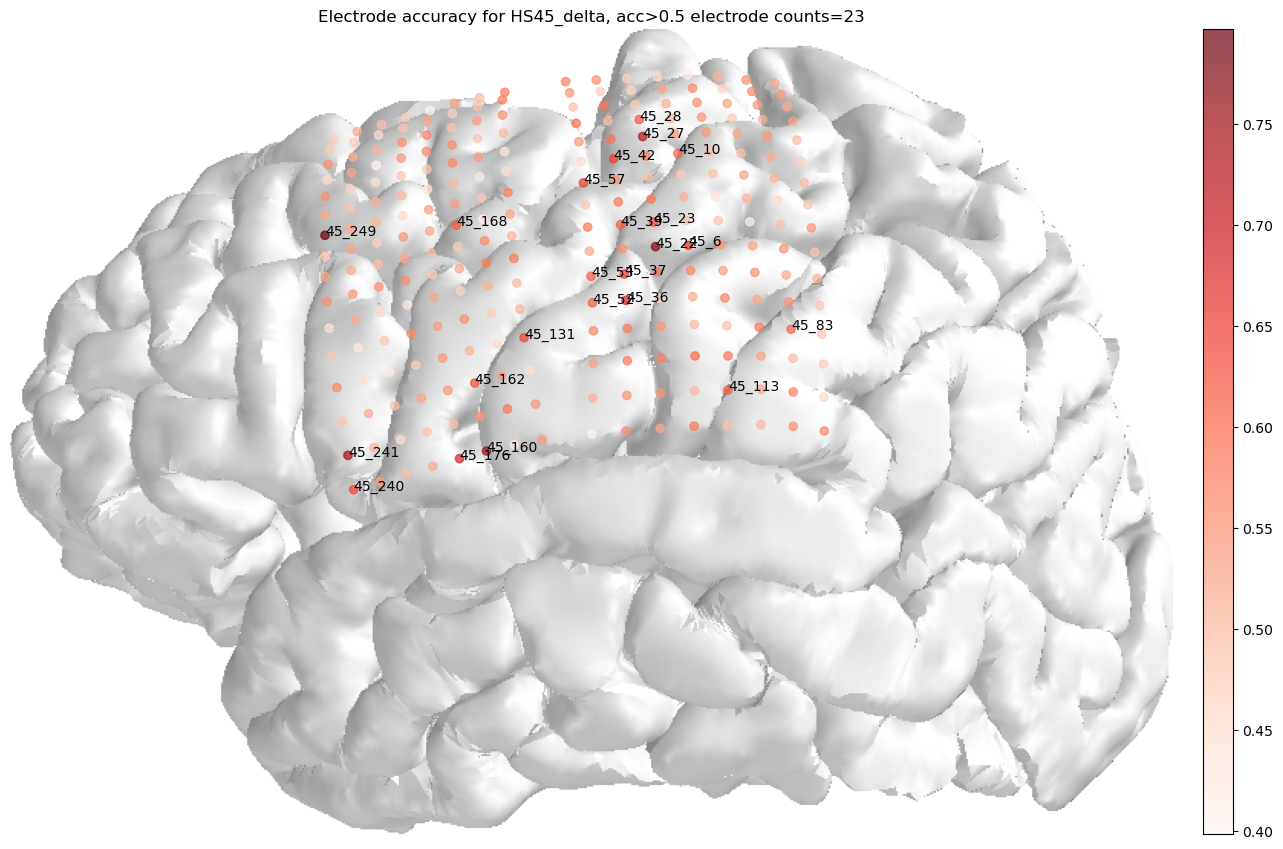

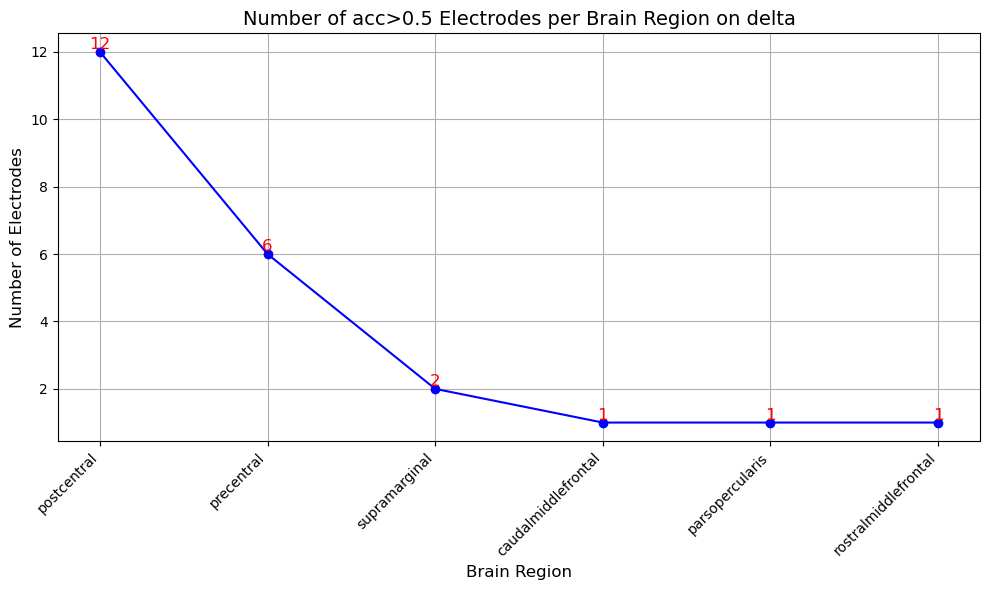

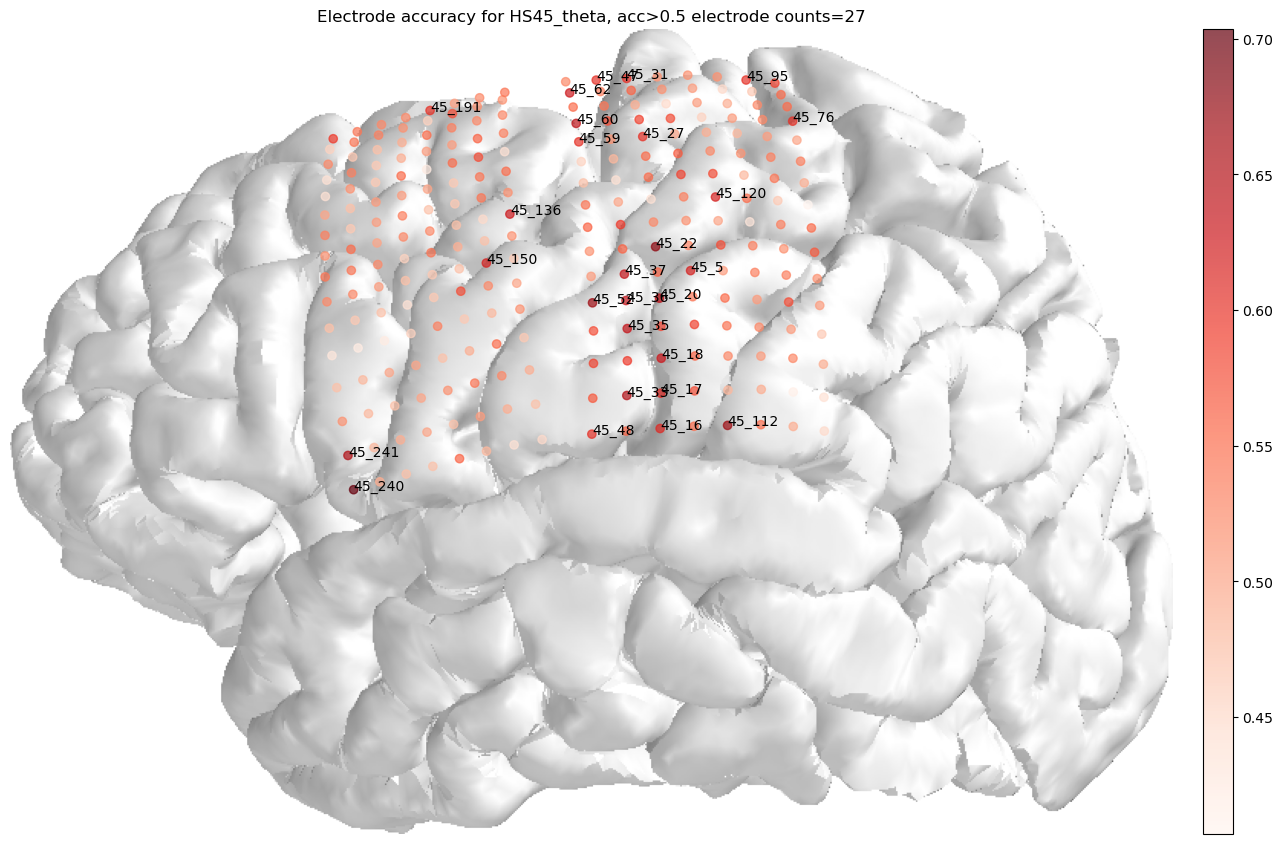

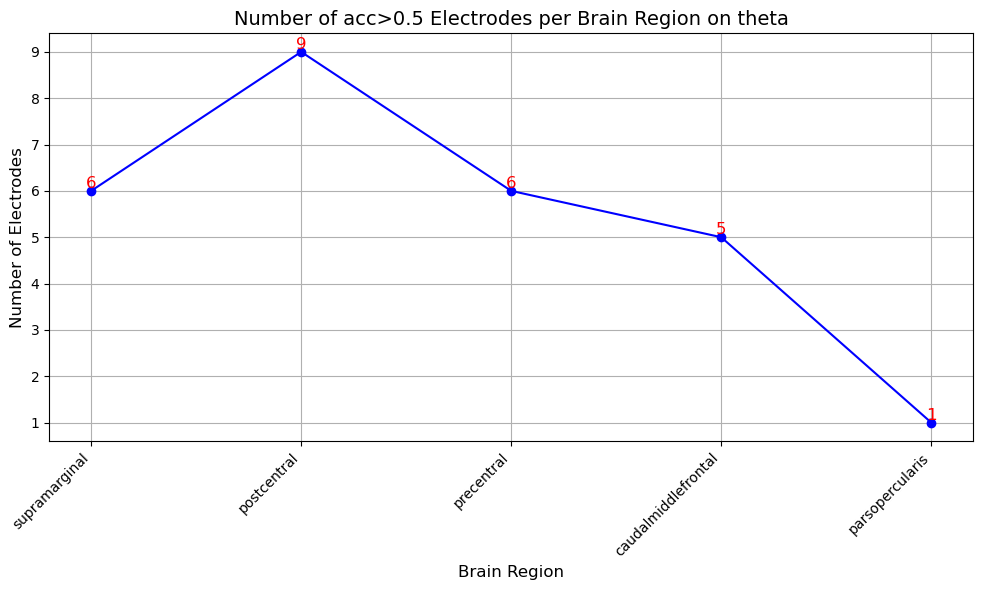

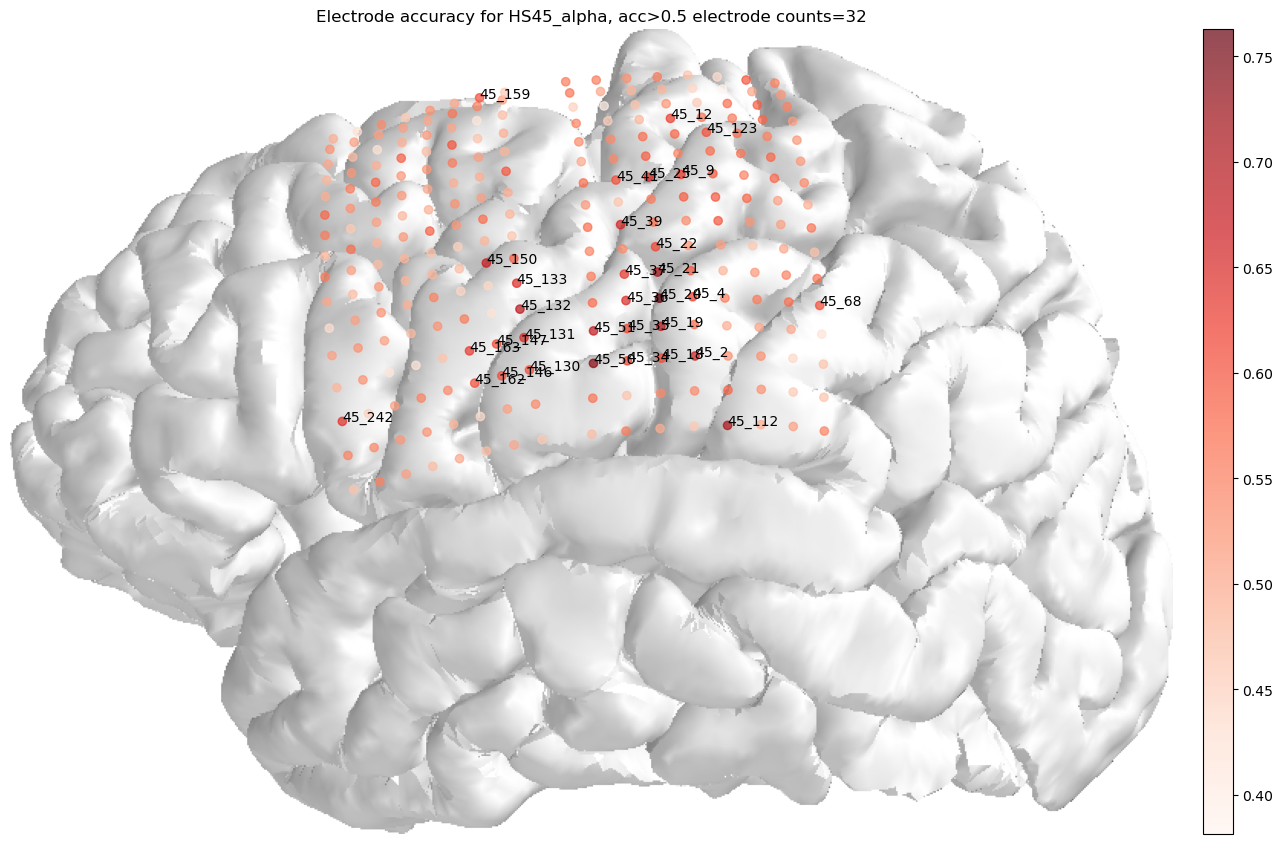

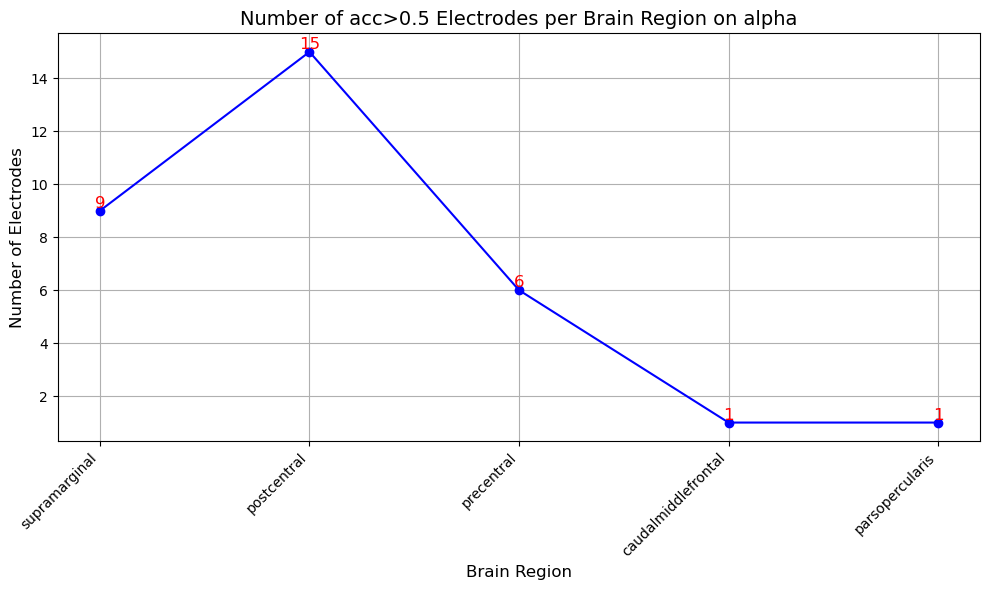

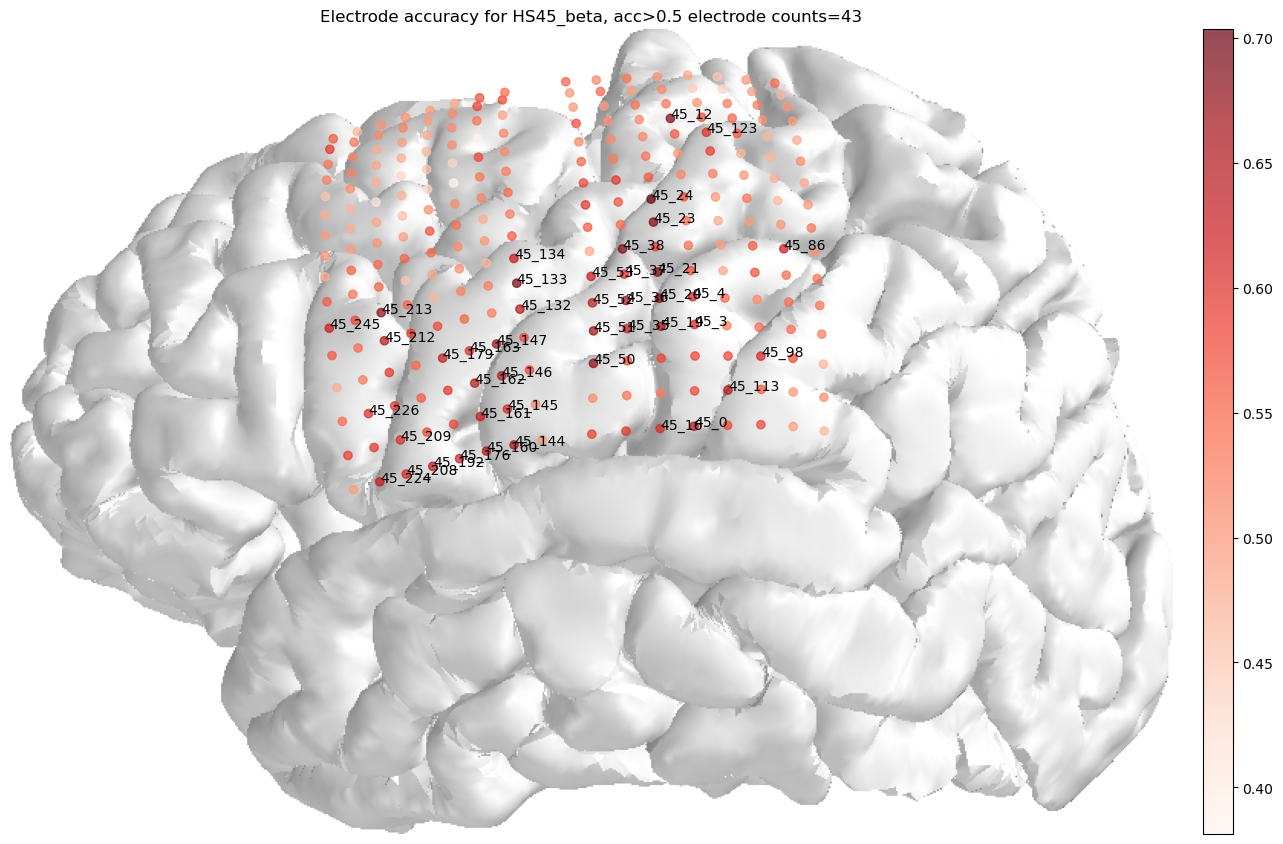

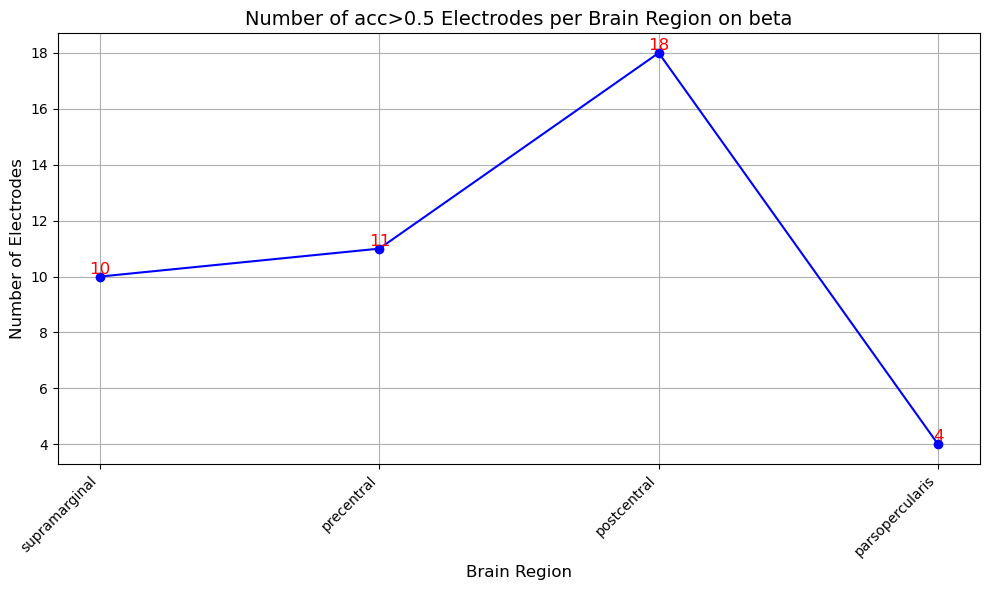

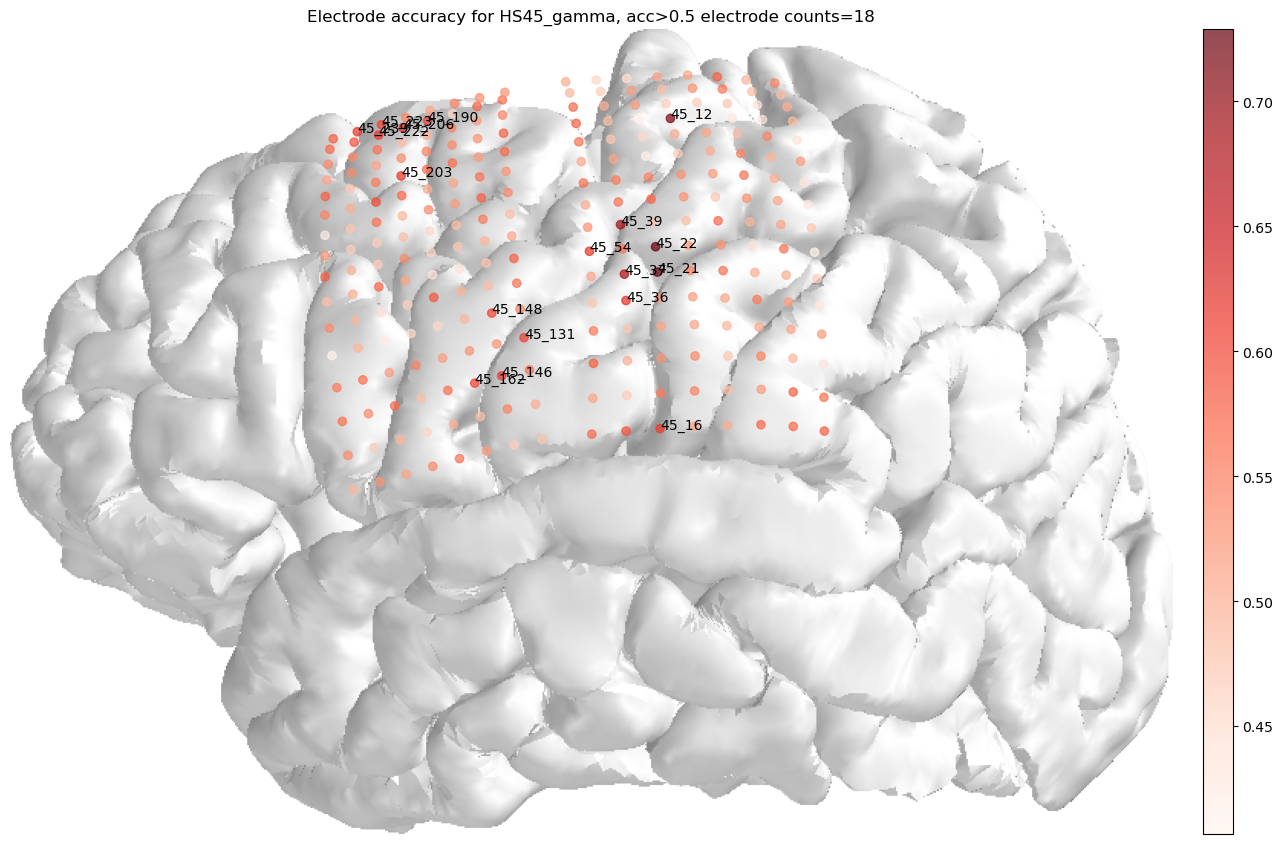

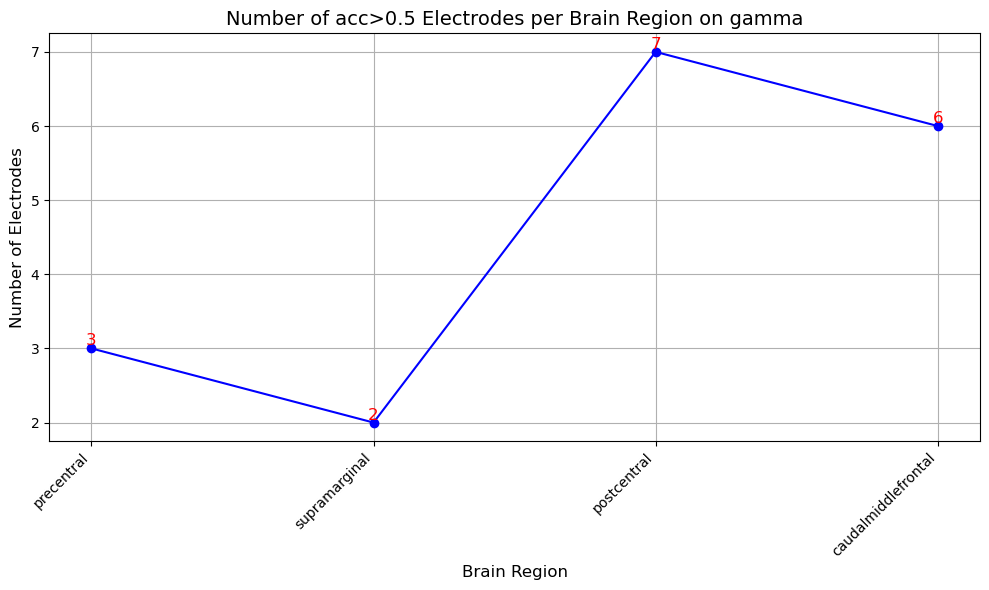

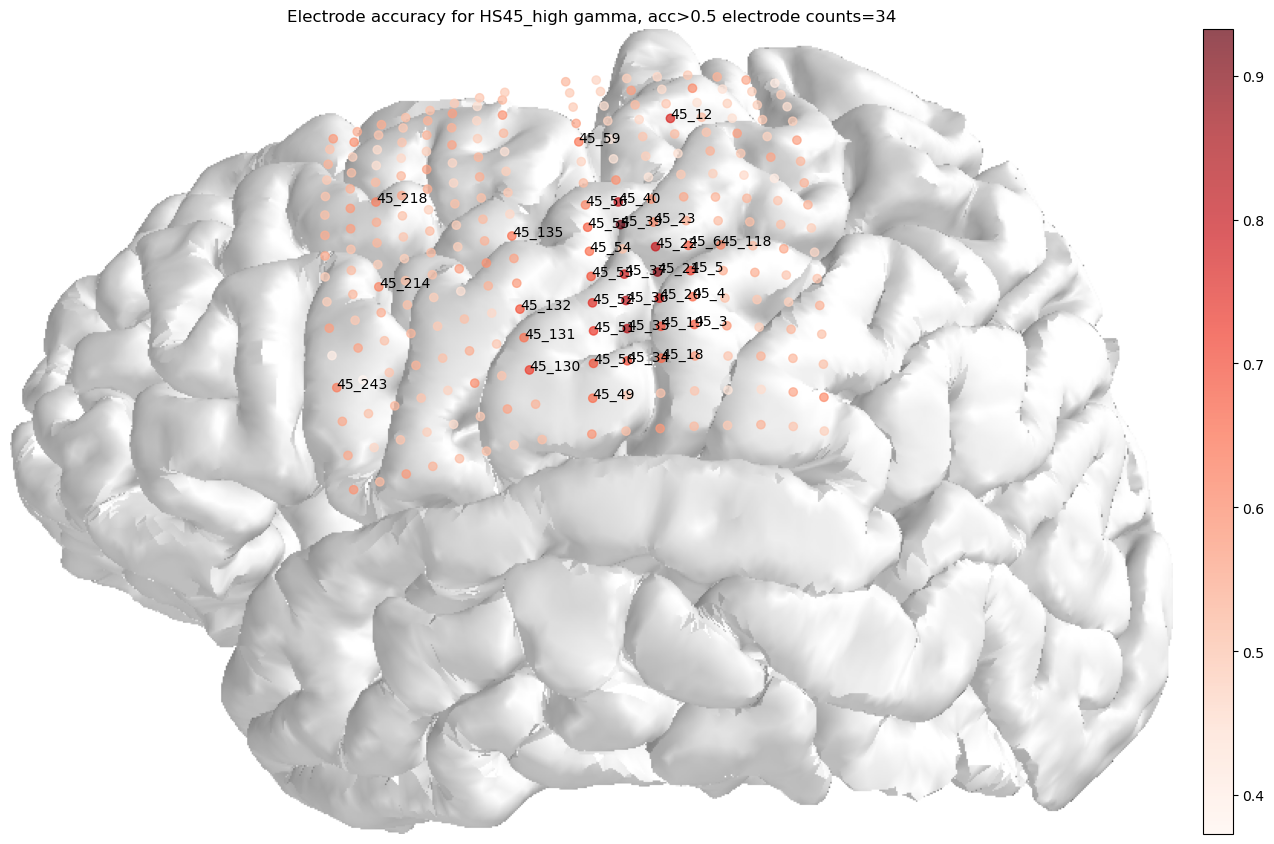

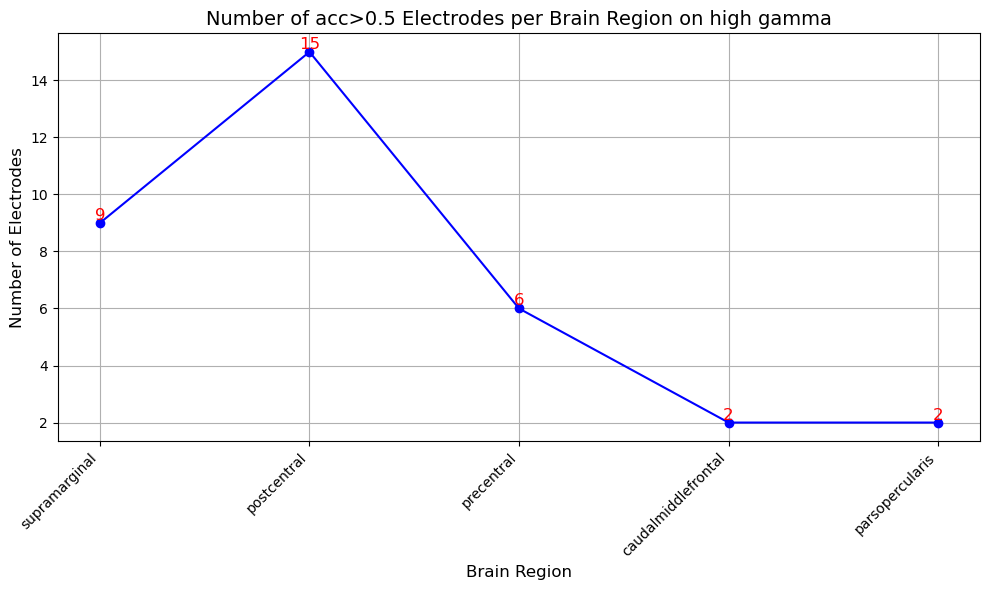

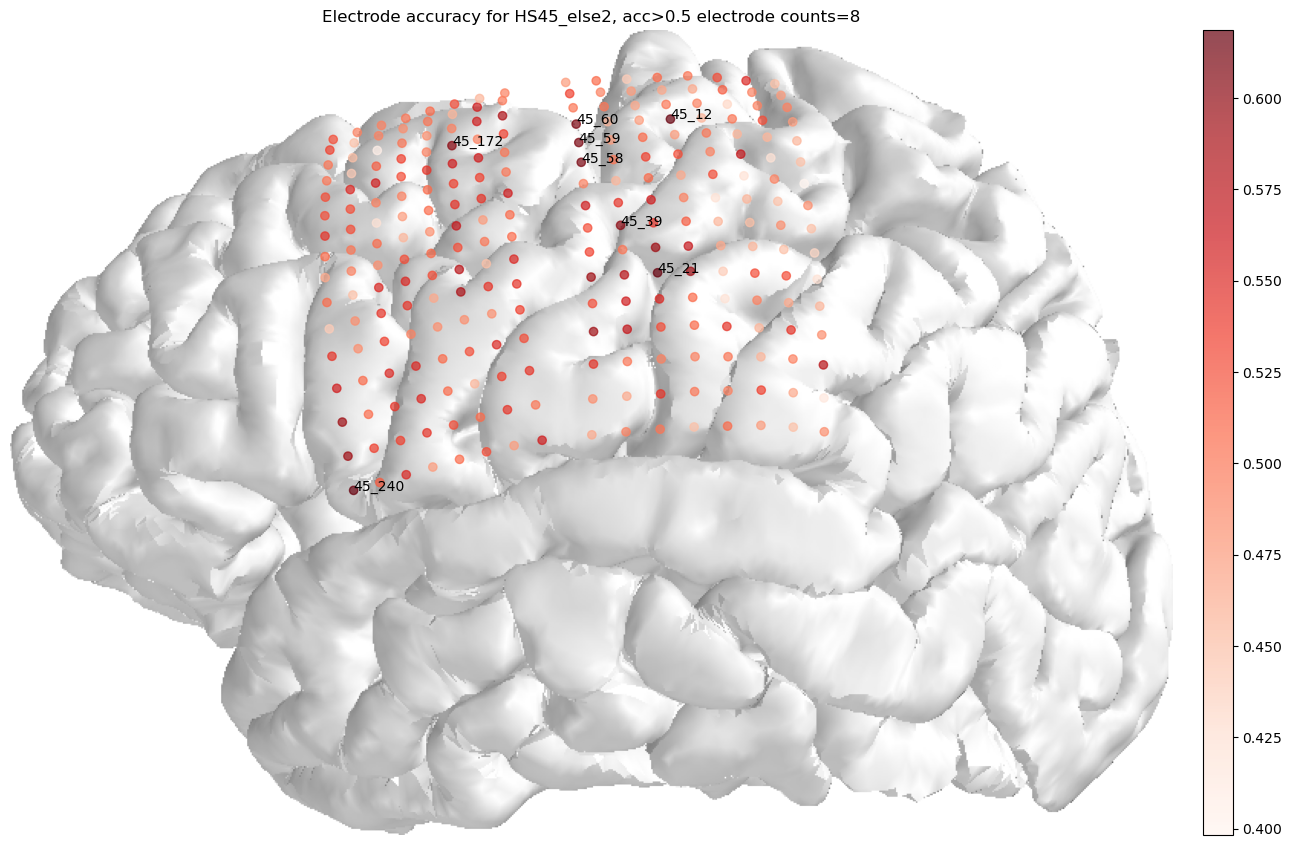

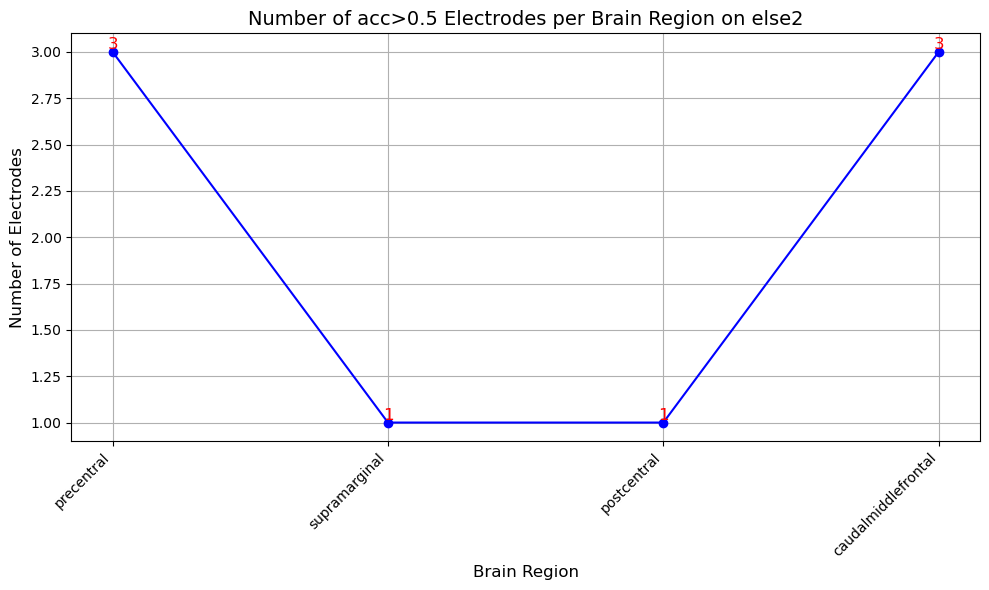

In [6]:
for band in bands_list:
    plot_bands_acc_elecs_brain(45, 400, band)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 示例数据
bands_list = ['delta', 'theta', 'alpha', 'beta', 'gamma']
anatomy = {elec: ['Area1', 'Area2', 'Area3', ['Region_A', 'Region_B']] for elec in range(256)}  # 电极的区域信息
band_elec_p_values = {'delta': [0.04, 0.06, 0.02], 'theta': [0.01, 0.3, 0.03], 'alpha': [0.05, 0.07, 0.04]}  # 假设的p值

# 初始化区域统计字典
region_count_by_band = {band: {} for band in bands_list}

# 遍历频段，统计p值小于0.05的电极区域分布
for band in bands_list:
    band_elec_list = [i for i, p in enumerate(band_elec_p_values.get(band, [])) if p < 0.05]  # p值小于0.05的电极
    for elec in band_elec_list:
        region = anatomy[elec][3][0]  # 选取第一级区域
        if region not in region_count_by_band[band]:
            region_count_by_band[band][region] = 0
        region_count_by_band[band][region] += 1

# 转换为DataFrame
df = pd.DataFrame(region_count_by_band).fillna(0)

# 计算各频段每个区域的电极数量百分比（用于标注）
df_percentage = df.div(df.sum(axis=0), axis=1) * 100

# 绘制堆叠柱状图
fig, ax = plt.subplots(figsize=(10, 6))
bottoms = np.zeros(len(df.columns))

for i, (region, row) in enumerate(df.iterrows()):
    ax.bar(df.columns, row, bottom=bottoms, label=region)
    bottoms += row

    # 添加百分比标注
    for j, (value, percent) in enumerate(zip(row, df_percentage.loc[region])):
        if percent > 1:  # 只显示超过1%的标签
            ax.text(j, bottoms[j] - value / 2, f'{percent:.1f}%', ha='center', va='center', color='white', fontsize=8)

# 图例和标签
plt.xlabel('Frequency Bands')
plt.ylabel('Number of Electrodes (p < 0.05)')
plt.title('Distribution of Significant Electrodes by Frequency Band with Percentage Annotations')
plt.legend(title='Brain Regions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
